# REINFORCE in Python

### 패키지 import
의존성 있는 패키지인 ``` numpy ```, ``` tensorflow ```, ``` keras ```를 import해야 한다.  
  
참고: keras는 단독으로 import하지 않고 반드시 ``` import tensorflow.keras as keras ```와 같이 ``` tensorflow ```를 통해 import해야 잠재적인 오류를 예방할 수 있다.  

주어진 모듈을 설치하기 위해서는 `pip install numpy`, `pip install tensorflow`를 실행하자.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow.keras as keras

## Policy Gradient - REINFORCE
### Model Building
REINFORCE는 Monte-Carlo 방식으로 policy-based learning을 진행하는 on-policy 강화학습법이다.  
  
먼저 늘 그렇듯 Policy Gradient(PG)를 위한 neural network를 정의하여야 한다. 기존에 작성하였던 방식은 `keras.Sequential`을 이용한 순차지향적 방식이었으나, 이번에는 조금 다르게 객체지향적 방식으로 `keras.Model` 클래스를 상속해 코드를 작성해 보겠다.

객체지향 방식은 간단하다. `keras.Model` 클래스를 상속한 후 `call(self, inputs)` 메서드를 구현해 주면 된다. 이때 neural net을 함수처럼 쌓아 주는 식으로 구현하면 편하다. 아래의 클래스 생성자에서 각각의 파라미터는 다음을 뜻한다.

* ``` l_rate ```는 학습률을 나타낸다.
* ``` n_actions ```는 tabular action의 개수를 나타낸다.
* ``` input_dims ```는 state의 feature dimension이다.

In [2]:
class ReinforceNetwork(keras.Model):
    def __init__(self, l_rate, n_actions, input_dims):
        super(ReinforceNetwork, self).__init__() # 상위 클래스의 생성자 호출
        self.l_rate     = l_rate
        self.n_actions  = n_actions
        self.input_dims = input_dims

        self.layer1 = keras.layers.Dense(64, activation='relu')
        self.layer2 = keras.layers.Dense(64, activation='relu')
        self.layer3 = keras.layers.Dense(n_actions, activation='softmax') # 확률이 출력이므로 activation = 'softmax'

        self.compile(optimizer=keras.optimizers.Adam(learning_rate=l_rate))

    def call(self, inputs):
        mid1 = self.layer1(inputs)
        mid2 = self.layer2(mid1)
        return self.layer3(mid2)

위의 `ReinforceNetwork` 클래스를 활용해 REINFORCE 강화학습을 진행하는 `EpisodicReinforceAgent` 클래스를 정의한다. 이 코드에서 PG는 **episodic reward**를 reward function으로 설정하였다. 정책 $\pi_\theta$에서 reward function $J(\theta)$는 다음과 같이 정의된다.

$$ J(\theta) = \mathbb{E}_{S_0 \sim d_0, \pi_\theta}\left[ \sum_{t=0}^{\infty}{\gamma^t R_{t+1}} \right] = \mathbb{E}_{S_0 \sim d_0, \pi_\theta}\left[ G_0 \right] = \mathbb{E}_{S_0 \sim d_0}\left[ v_{\pi_\theta} (S_0) \right] $$

Policy Gradient Theorem(episodic)에 의하여, 위 식의 그래디언트인 $\nabla_\theta J(\theta)$ 는 다음과 같다.

$$ \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \left. \sum_{t=0}^{T}{\gamma^t q_{\pi_\theta}(S_t, A_t) \nabla_\theta \log \pi_\theta (A_t \mid S_t)} \right| S_0 \sim d_0 \right]$$

이때 $q_{\pi_\theta}(S_t, A_t) = \mathbb{E}_{\pi_\theta}\left[ \left. G_t \right| S_t, A_t \right]$ 이므로 지금과 같은 stochastic 조건 하에서 $q_{\pi_\theta}(S_t, A_t) \approx G_t$ 로 간주할 수 있다. 또한 일반적으로 $\gamma^t$ 항은 생략한다. 따라서 업데이트는 다음과 같이 이루어진다.

$$ t \in \{ 0, 1, ..., N \}: \theta \leftarrow \theta + \alpha G_t \nabla_\theta \log \pi_\theta (A_t \mid S_t) $$

In [3]:
def categoricalSelect(L):
    ''' L[i] 확률로 i를 반환하는 함수. 어떠한 i에도 해당하지 않으면 0 반환. 0 <= sum(L) <= 1인 경우에만 정의됨.'''
    L = list(tf.squeeze(L))
    pick = np.random.random()
    cumul = 0

    for i, pi in enumerate(L):
        if (cumul <= pick < cumul + float(pi)):
            return i
        cumul += pi

    return 0

class ReinforceAgent:
    def __init__(self, input_dims, l_rate, gamma, n_actions, filename):
        # PG 특성상 epsilon은 사용하지 아니함
        self.read_only = False
    
        self.gamma = gamma
        self.action = [i for i in range(n_actions)]

        self.policy = ReinforceNetwork(l_rate, n_actions, input_dims)

        # 하나의 episode에 대하여만 행동을 기록하는 배열
        self.state, self.action, self.reward = \
            list(), list(), list()

        # model 저장용
        self.filename = filename
    
    def choose_action(self, obs):
        ''' 내부 stochastic policy인 `self.policy`를 토대로 action 결정 '''
        state = np.array([obs], dtype=np.float32) # 관찰 결과를 numpy 스타일로 변환 (tf.convert_to_tensor도 ok)
        pr = self.policy(state) # 신경망으로 전달, 확률 pr에 저장
        return categoricalSelect(pr)

    def store(self, state, action, reward):
        ''' 데이터 저장. 여기서 state는 엄밀하게는 observation을 뜻함. '''
        if self.read_only:
            raise Exception("ReinforceDeploy class can only use model, not store.")
            return

        self.state.append(state)
        self.action.append(action)
        self.reward.append(reward)

    def learn(self):
        ''' Monte-Carlo 방식으로 강화학습 진행. 이후 episode는 폐기 '''
        # 잡지식 하나: np.array와 tf.Tensor의 차이점은?
        # 정답: 내부구조는 거의 완벽히 동일해서 변환은 constant time 안에 가능.
        # 다만 tf.Tensor는 GPU에도 저장할 수 있음
        if self.read_only:
            raise Exception("ReinforceDeploy class can only use model, not learn.")

        reward = tf.convert_to_tensor(self.reward, dtype=np.float32)
        
        G = np.zeros(reward.shape) # G value (미래누적보상) 저장
        for t in reversed(range(len(reward))): # G값 계산하는 코드
            if t == len(reward)-1:
                # 종료 케이스. 미래보상 없음
                G[t] = reward[t]
            else:
                # 미래보상 할인율 gamma 적용
                G[t] = reward[t] + self.gamma * G[t+1]

        # 입력에 따른 self.policy의 그래디언트 기록
        # *** 상당히 어려운 부분임: https://www.tensorflow.org/guide/autodiff 읽어볼것
        with tf.GradientTape() as tape:
            Loss = 0
            for t, (gt, st) in enumerate(zip(G, self.state)):
                state = tf.convert_to_tensor([st], dtype=tf.float32) # 텐서화
                Pr = tf.squeeze(self.policy(state)) # 신경망 투입으로 학습가능 파라미터의 gradient 기록
                LogPr = tf.math.log(Pr[self.action[t]]) # 그 당시 골랐던 action에 log끼움
                Loss -= gt * LogPr # Gradient Ascent이므로 Loss에서 "빼" 줌
 
        # 기록은 종료됨. 기록된 그래디언트 적용해 경사하강
        grad = tape.gradient(Loss, self.policy.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(grad, self.policy.trainable_variables))
        
        # episode learning 끝. 배열 초기화
        self.state, self.action, self.reward = \
            list(), list(), list()

    def save_model(self):
        if self.read_only:
            raise Exception("ReinforceDeploy class can only use model, not save.")
            return

        self.policy.save(self.filename)
    
    def load_model(self):
        self.policy = keras.models.load_model(self.filename)

class ReinforceDeploy(ReinforceAgent):
    ''' Model의 학습과 저장은 불가능하고 오직 사용만을 위한 class '''
    def __init__(self, filename):
        self.filename = filename
        self.read_only = True
        self.load_model()

## Model Evaluating

### Gym을 사용한 가상환경 준비
OpenAI에서 제공하는 gym 모듈을 사용해 보자. 이 모듈은 `pip install gym`을 통해 설치할 수 있다.

In [6]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

env = HTS(1000000, 0.0002)
observation = env.reset()

### Agent 학습
아래의 코드 블록을 실행하면 랜덤하게 초기화된 cartAgent가 강화학습을 시작한다.

  0%|          | 0/1000 [00:00<?, ?it/s]

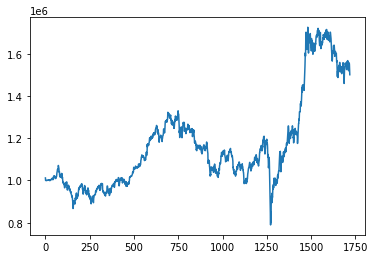

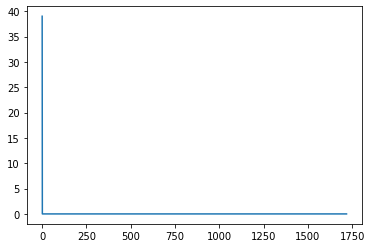

score 139126753.0 | recent average score 139126753.0:   0%|          | 0/1000 [00:07<?, ?it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 139126753.0 | recent average score 139126753.0:   0%|          | 1/1000 [00:07<2:07:29,  7.66s/it]

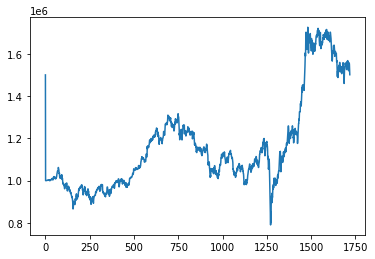

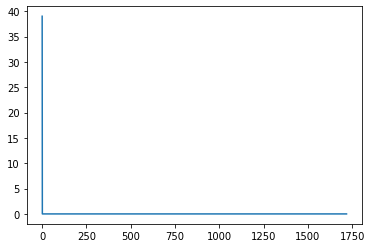

score -319418947.0 | recent average score -90146097.0:   0%|          | 2/1000 [00:14<1:58:21,  7.12s/it]

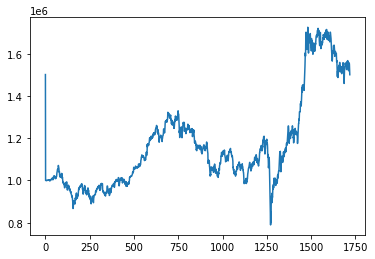

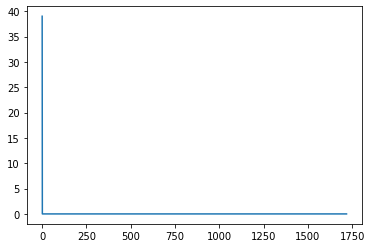

score -314465254.0 | recent average score -164919149.3:   0%|          | 3/1000 [00:20<1:53:01,  6.80s/it]

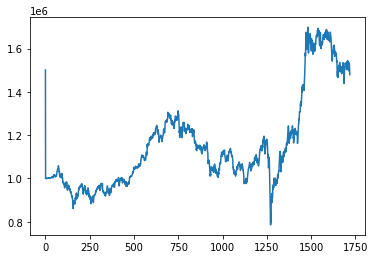

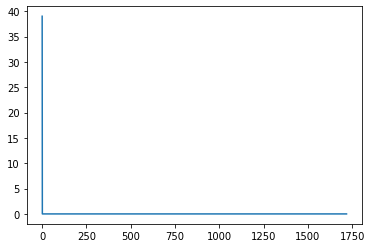

score -318925666.0 | recent average score -203420778.5:   0%|          | 4/1000 [00:27<1:51:51,  6.74s/it]

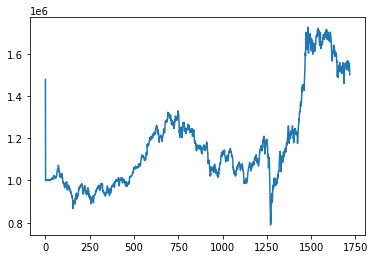

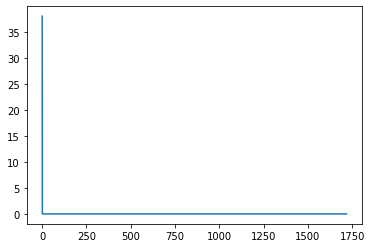

score -269838607.0 | recent average score -216704344.2:   0%|          | 5/1000 [00:34<1:50:49,  6.68s/it]

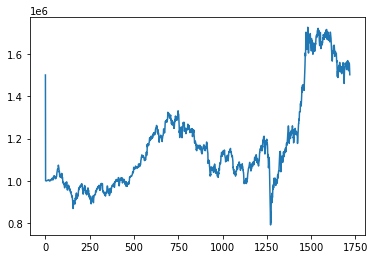

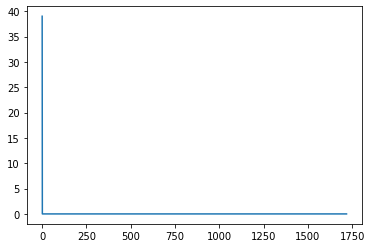

score -312122385.0 | recent average score -232607351.0:   1%|          | 6/1000 [00:41<1:53:12,  6.83s/it]

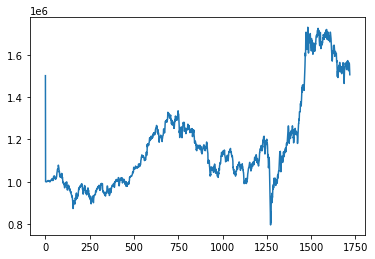

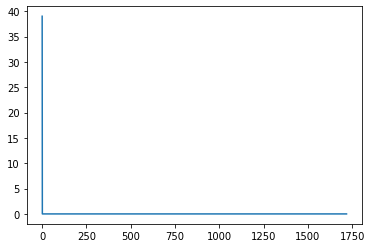

score -283823244.0 | recent average score -239923907.1:   1%|          | 7/1000 [00:47<1:52:24,  6.79s/it]

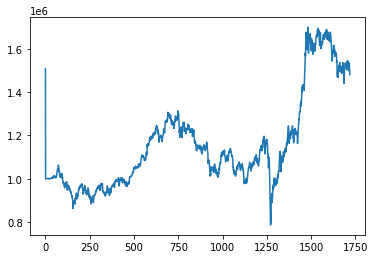

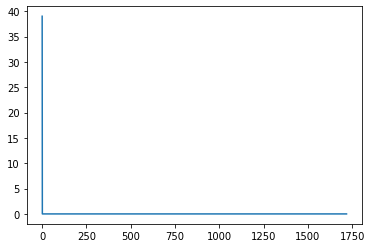

score -319881160.0 | recent average score -249918563.8:   1%|          | 8/1000 [00:54<1:52:35,  6.81s/it]

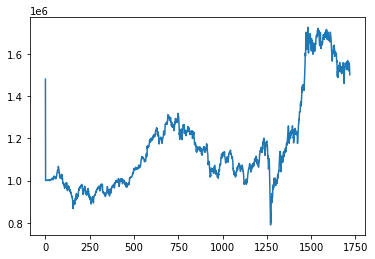

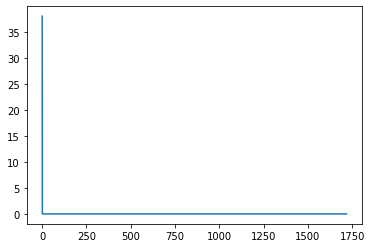

score -298933512.0 | recent average score -255364669.1:   1%|          | 9/1000 [01:01<1:53:20,  6.86s/it]

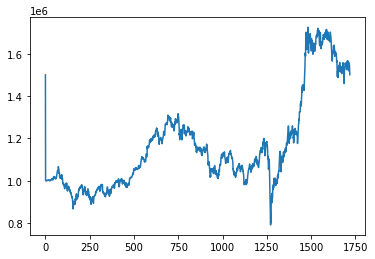

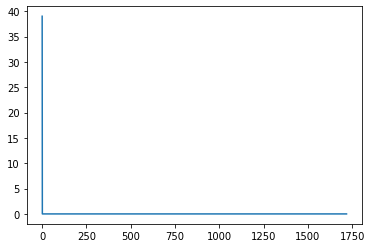

score -310564102.0 | recent average score -260884612.4:   1%|          | 10/1000 [01:08<1:53:47,  6.90s/it]

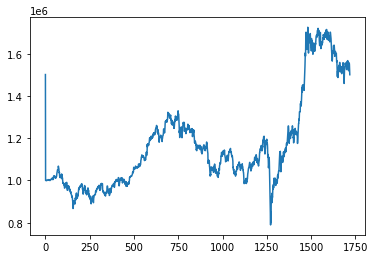

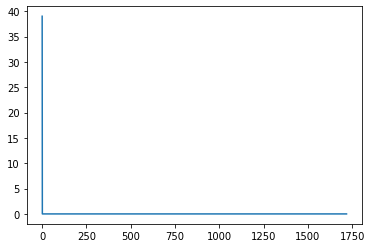

score -288716671.0 | recent average score -263414799.5:   1%|          | 11/1000 [01:16<1:56:03,  7.04s/it]

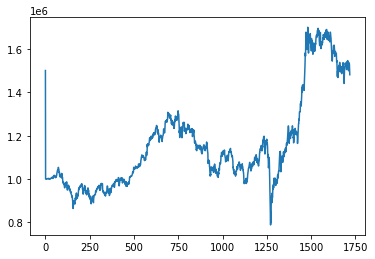

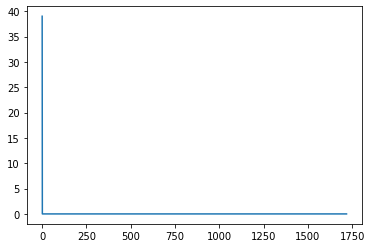

score -298604453.0 | recent average score -266347270.7:   1%|          | 12/1000 [01:22<1:55:05,  6.99s/it]

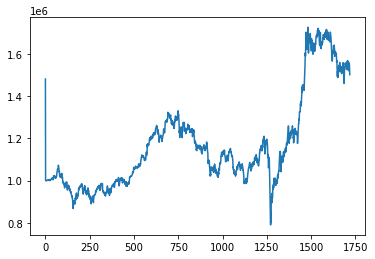

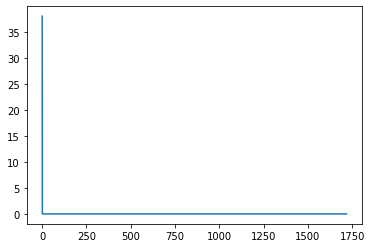

score -259946430.0 | recent average score -265854898.3:   1%|▏         | 13/1000 [01:29<1:54:47,  6.98s/it]

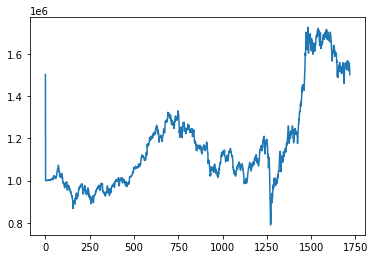

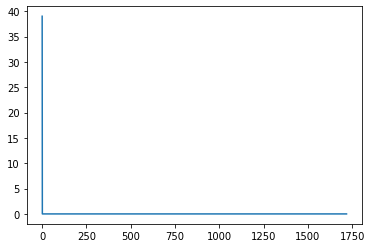

score -289588746.0 | recent average score -267550173.1:   1%|▏         | 14/1000 [01:36<1:52:14,  6.83s/it]

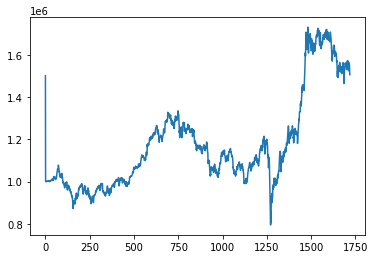

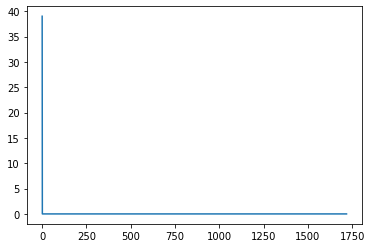

score -263305349.0 | recent average score -267267184.9:   2%|▏         | 15/1000 [01:43<1:51:58,  6.82s/it]

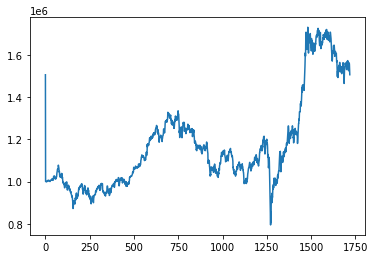

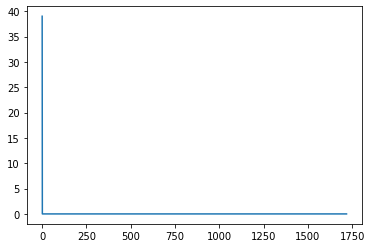

score -276545610.0 | recent average score -267847086.4:   2%|▏         | 16/1000 [01:50<1:52:20,  6.85s/it]

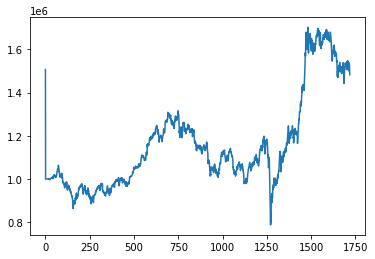

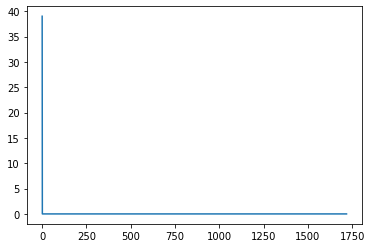

score -283921036.0 | recent average score -268792612.9:   2%|▏         | 17/1000 [01:57<1:53:03,  6.90s/it]

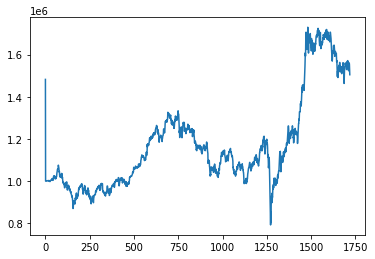

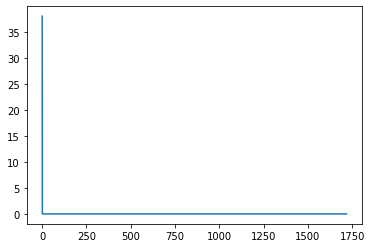

score -255235822.0 | recent average score -268039457.8:   2%|▏         | 18/1000 [02:04<1:52:51,  6.90s/it]


KeyboardInterrupt: 

In [9]:
cartAgent = ReinforceAgent(
    input_dims=25, 
    l_rate=0.0003, 
    gamma=0.98,
    n_actions=2,
    filename='cartpole-reinforce'
)

scores, scores_avg = list(), list()
prgress = tqdm(range(1000))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartAgent.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)
        cartAgent.store(obs_this, action, reward)
        
        # 보상 저장
        score += reward
        obs_this = obs_next
        # env.render() # 렉 걸릴 경우 제외

    env.plot()

    # Agent 학습
    cartAgent.learn()

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:]))  # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f}".format(scores[-1], scores_avg[-1]))

    if episode % 50 == 0: # 50 episode마다 모델을 저장
        cartAgent.save_model()

plt.plot(np.arange(len(scores)), np.array(scores_avg)) # 이동평균 점수 그래프 그리기

In [5]:
# portfolio optimization with KODEX200 and cash

class HTS:
    def __init__(self, cash_init, fee=0.0002, start=0, end=0):
        self.KOSPI = pd.read_csv('KODEX200.csv')

        #process data
        self.KOSPI.drop('Adj Close', axis=1, inplace=True)
        self.KOSPI.drop('Date', axis=1, inplace=True)
        self.KOSPI.dropna(inplace=True)
        indice =   (self.KOSPI!=0).all(axis=1)
        self.KOSPI =     self.KOSPI.loc[indice]
        self.KOSPI =     self.KOSPI.reset_index(drop=True)
        if end == 0:
            end = len(self.KOSPI)
        self.KOSPI = self.KOSPI.loc[start:end]

        self.original_KOSPI = pd.DataFrame.copy(self.KOSPI)
        max_vals = [self.KOSPI['Open'].max(), self.KOSPI['High'].max(), self.KOSPI['Low'].max(), self.KOSPI['Close'].max(), self.KOSPI['Volume'].max()]

        self.KOSPI['Open'] =   self.KOSPI['Open'].apply(lambda x : x/max_vals[0])
        self.KOSPI['High'] =   self.KOSPI['High'].apply(lambda x : x/max_vals[1])
        self.KOSPI['Low'] =    self.KOSPI['Low'].apply(lambda x : x/max_vals[2])
        self.KOSPI['Close'] =  self.KOSPI['Close'].apply(lambda x : x/max_vals[3])
        self.KOSPI['Volume'] = self.KOSPI['Volume'].apply(lambda x : x/max_vals[4])


        self.finish = len(self.KOSPI)-1
        self.cash = cash_init
        self.cash_init = cash_init
        self.stock = 0
        self.day = 4
        self.observation_space = 5*5 # OHLCV * 5days
        self.action_space = 2 # KODEX200, cash
        self.fee = fee
        self.current_stock_price = int(self.original_KOSPI.iloc[self.day].to_numpy()[3])

        self.buy(1)
        self.total_balance_history = [self.cash+self.stock*self.current_stock_price]
        self.stock_history = [self.stock]

    def __str__(self):
        return 'Total Asset: {}\nCash: {}\nStock: {}\nReward: {:.2f}\n' \
            .format(self.total_balance_history[-1], self.cash, self.stock, self.get_reward())
        
    # 초기 환경으로 reset
    def reset(self):

        self.finish = len(self.KOSPI)-1
        self.day = 4
        self.buy(1)
        self.total_balance_history = [self.cash+self.stock*self.current_stock_price]
        self.stock_history = [self.stock]

        self.cash = self.cash_init
        self.stock = 0
        self.observation = self.get_features()
        self.current_stock_price = int(self.original_KOSPI.iloc[self.day].to_numpy()[3])
        
        return self.observation

    # 5일간의 OHLCV 리턴
    def get_features(self):
        # day1 = np.array([self.KOSPI.iloc[self.day-4][3]])#.to_numpy()
        # day2 = np.array([self.KOSPI.iloc[self.day-3][3]])#.to_numpy()
        # day3 = np.array([self.KOSPI.iloc[self.day-2][3]])#.to_numpy()
        # day4 = np.array([self.KOSPI.iloc[self.day-1][3]])#.to_numpy()
        # day5 = np.array([self.KOSPI.iloc[self.day  ][3]])#.to_numpy()

        day1 = self.KOSPI.iloc[self.day-4].to_numpy()
        day2 = self.KOSPI.iloc[self.day-3].to_numpy()
        day3 = self.KOSPI.iloc[self.day-2].to_numpy()
        day4 = self.KOSPI.iloc[self.day-1].to_numpy()
        day5 = self.KOSPI.iloc[self.day  ].to_numpy()
        return np.concatenate((day1, day2, day3, day4, day5), axis=0)

    # take action
    def step(self, action): #action is (1*2) tensor with softmax ratio
        #action = action.numpy()
        #KODEX200_ratio = action[0][0]
        opt_stock_deposit = 0
        self.current_stock_price = int(self.original_KOSPI.iloc[self.day].to_numpy()[3])
        total_balance = self.cash+self.stock*self.current_stock_price

        # for i in range(total_balance):

        #     stock_ratio = i*self.current_stock_price / total_balance

        #     #print(stock_ratio, KODEX200_ratio)
        #     # if the ratio is smaller than the target
        #     if  stock_ratio < KODEX200_ratio:
        #         opt_stock_deposit = i
            
        #     # get the optimal between i and i+1, take the value with smaller error
        #     # but use smaller value when exceeds the cash limit
        #     elif abs(i*self.current_stock_price / total_balance - KODEX200_ratio) > \
        #         abs((i-1)*self.current_stock_price / total_balance - KODEX200_ratio):

        #         if i*self.current_stock_price <= total_balance:
        #             if i == 1:
        #                 opt_stock_deposit = 0
        #                 break
        #             opt_stock_deposit = i
                
        #         else:
        #             if i*self.current_stock_price > total_balance-i*self.current_stock_price*self.fee:
        #                 opt_stock_deposit = i-2
        #             else:
        #                 opt_stock_deposit = i-1
        #         break
        #     else:

        #         if i*self.current_stock_price <= total_balance:
        #             opt_stock_deposit = i
        #         else:
        #             opt_stock_deposit = i-1
        #         break
        #quantity = 0
        is_improper = False
        if action == 0:
            is_improper = self.buy(1)
        elif action == 1:
            pass
        else:
            is_improper = self.buy(-1)
        self.stock_history.append(opt_stock_deposit)
        total_balance = self.cash+self.stock*self.current_stock_price
        self.total_balance_history.append(total_balance)
        done = 0
        if self.day == self.finish:
            done = 1
        else:
            self.day += 1

        reward = self.get_reward()
        if is_improper:
            reward = -1000

        return self.get_features(), reward, done, None
    
    def buy(self, volume):
        if self.cash > volume*self.current_stock_price:
            self.stock += volume
            if volume > 0:
                self.cash -= int((volume*self.current_stock_price)*(1+self.fee))
            if volume < 0:
                self.cash -= int((volume*self.current_stock_price))
                self.cash += int((volume*self.current_stock_price)*(self.fee))
        else:
            return True
        

    def get_reward(self):

        # #sharpe ratio but not using US treasury bond profit
        # std_dev = 0

        # if len(self.total_balance_history) == 1:
        #     return 0

        # for i in range(len(self.total_balance_history)-1):
        #     std_dev += abs((self.total_balance_history[i+1] - self.total_balance_history[i])
        #             /self.total_balance_history[i] * 100)

        # profit = (self.total_balance_history[-1] - self.total_balance_history[0]) \
        #         / self.total_balance_history[0] * 100


        # return profit / std_dev
        #print(self.total_balance_history[-1],  self.total_balance_history[-2])
        
        return self.total_balance_history[-1] - self.total_balance_history[0]

    def plot(self):

        plt.plot(range(len(self.total_balance_history)), self.total_balance_history)
        #plt.axes().set_facecolor('white')
        plt.savefig('account.png', dpi=300)
        plt.show()
        
        plt.plot(range(len(self.stock_history)), self.stock_history)
        #plt.axes().set_facecolor('white')
        plt.savefig('stock.png', dpi=300)
        plt.show()

다음은 학습한 모델을 불러와 실행하는 블록이다.

score 338.0 | recent average score 335.9: 100%|██████████| 50/50 [02:02<00:00,  2.44s/it]


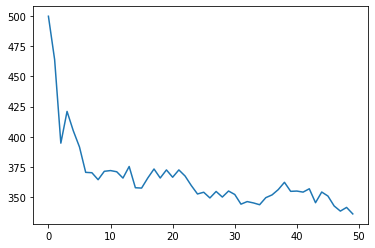

In [8]:
cartDeploy = ReinforceDeploy('cartpole-reinforce')

scores, scores_avg = list(), list()
prgress = tqdm(range(50))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartDeploy.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)
        
        # 보상 저장
        score += reward
        obs_this = obs_next
        env.render()

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:]))  # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f}".format(scores[-1], scores_avg[-1]))

plt.plot(np.arange(len(scores)), np.array(scores_avg)) # 이동평균 점수 그래프 그리기

### 참고: Gradient Tape
Tensorflow는 복잡한 함수의 gradient를 직접 구하지 않아도 gradient를 자동으로 계산해 주고 반영할 수 있게 해 준다. 아래의 예제들을 통해 이해하여 보자.

In [ ]:
x = tf.Variable(3.0)
y = tf.Variable(2.0)
with tf.GradientTape() as tape:
    Loss = tf.math.log(x) + y
    print(type(Loss))

grad = tape.gradient(Loss, x)
print("Grad: {}".format(grad))

In [ ]:
W = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape() as tape:
  y = x @ W + b
  Loss = tf.reduce_mean(y**2)

# 만약 tape.gradient(Loss, W); tape.gradient(Loss, b)와 같이 두 번에 걸쳐 계산하려면
# .gradient를 두 번 호출한다. 이 경우 with절에서 tf.GradientTape(persistent=True)를 사용해야 한다.
gW, gb = tape.gradient(Loss, [W, b]) 
assert W.shape == gW.shape and b.shape == gb.shape
print("gW\n{}\n*********\ngb\n{}".format(gW, gb))

In [ ]:
import tensorflow_probability as tfp

Qs = tfp.distributions.Categorical(probs=[0.1, 0.5, 0.4])
L = [Qs.sample() for i in range(100)]
Pr = [L.count(i) / len(L) for i in [0, 1, 2]]
print(Pr)
print(Qs.prob(0))
print(tf(Qs.prob(0)))
print(Qs.log_prob(0))
print(type(Qs.log_prob(0)))
print(type())
